## Korean_food Multi Label Classification

In [1]:
import os
import zipfile
from zipfile import ZipFile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# 데이터 종류별 폴더
data_dir='c:/data/k_food/'

In [3]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,  # 훈련데이터
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4000 files belonging to 4 classes.
Using 3200 files for training.
Found 4000 files belonging to 4 classes.
Using 800 files for validation.


In [4]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [6]:
class_names = train_ds.class_names
class_names[0]='갈비구이'
class_names[1]='갈치구이'
class_names[2]='곱창구이'
class_names[3]='삼겹살'
print(class_names)

['갈비구이', '갈치구이', '곱창구이', '삼겹살']


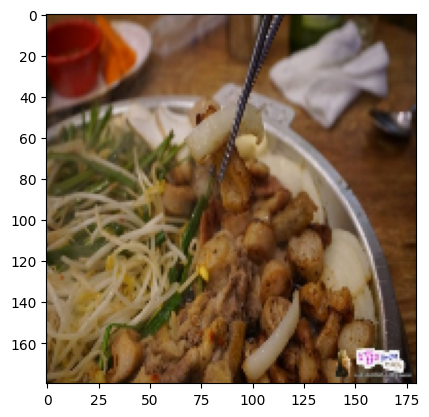

In [7]:
list(train_ds)[0][0]
img=list(train_ds)[0][0][0]
plt.imshow(img.numpy().astype('uint8'))

In [8]:
##### 성능 높이기

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.4),
  ]
)

In [46]:
num_classes = len(class_names)

# input size (180,180)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),  
  # layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # (90,90)
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),  # (45,45)
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), # (23,23,64)
  layers.Dropout(0.2),  
  layers.Flatten(), # 23*23*64
  layers.Dense(128, activation='relu'), 
  layers.Dense(num_classes, activation='softmax')
])

In [47]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


############### checkpoint ############### 
from tensorflow.keras.callbacks import ModelCheckpoint
modelpath="c:/data/model/k-food_bestmodel.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, verbose=1, monitor='val_loss', save_best_only=True) #verbose기본값이 0임, 1을 지정하지 않으면 결과가 화면에 출력되지 않음

# #러닝레이트의 비율을 유동적으로 변화할 수 있도록 설정함
# def scheduler(epoch, learning_rate):
#     if epoch < 10:
#         return learning_rate
#     else:
#         return learning_rate * tf.math.exp(-0.1)
# lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler) # 러닝레이트 설정

In [48]:
from keras.callbacks import EarlyStopping

epochs=20
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            # callbacks=[checkpointer,lr_scheduler_cb]
)

Epoch 1/20


100/100 [==============================] - 3s 21ms/step - loss: 1.3467 - accuracy: 0.3487 - val_loss: 1.2694 - val_accuracy: 0.4038
Epoch 2/20
100/100 [==============================] - 2s 20ms/step - loss: 1.1905 - accuracy: 0.4591 - val_loss: 1.1374 - val_accuracy: 0.4975
Epoch 3/20
100/100 [==============================] - 2s 20ms/step - loss: 1.1674 - accuracy: 0.4666 - val_loss: 1.1117 - val_accuracy: 0.4988
Epoch 4/20
100/100 [==============================] - 2s 20ms/step - loss: 1.1002 - accuracy: 0.5281 - val_loss: 1.1352 - val_accuracy: 0.5263
Epoch 5/20
100/100 [==============================] - 2s 20ms/step - loss: 1.0776 - accuracy: 0.5444 - val_loss: 1.0102 - val_accuracy: 0.5838
Epoch 6/20
100/100 [==============================] - 2s 19ms/step - loss: 1.0255 - accuracy: 0.5622 - val_loss: 1.0196 - val_accuracy: 0.5888
Epoch 7/20
100/100 [==============================] - 2s 19ms/step - loss: 0.9967 - accuracy: 0.5800 - val_loss: 1.0117 - val_accuracy: 0.5863
Epoch 8/20

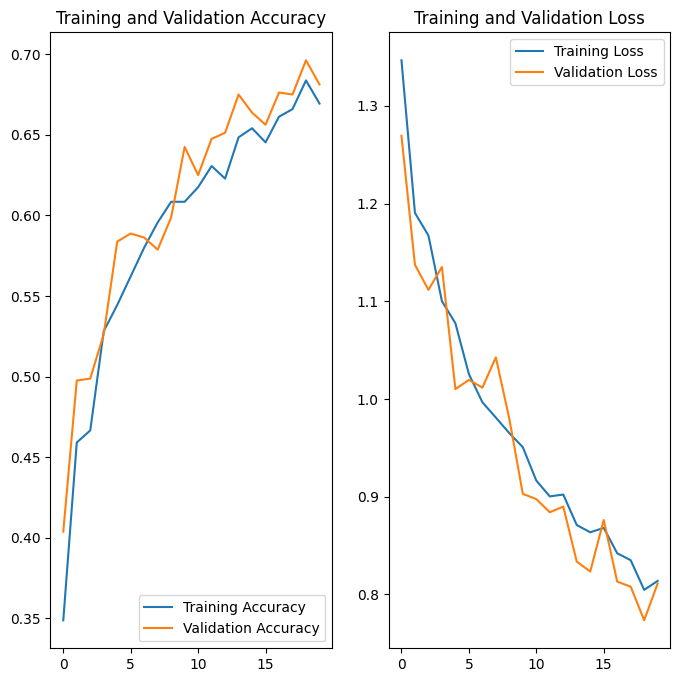

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
import tensorflow as tf
model = tf.keras.models.load_model('c:/data/model/k-food_bestmodel.hdf5')

삼겹살 [0.7591681]


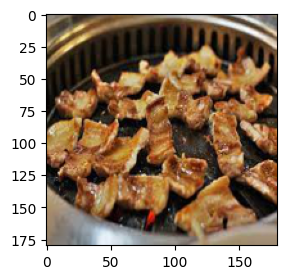

In [56]:
from PIL import Image
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

file='c:/data/test_img/food1.jpg'
img=Image.open(file).resize((180,180)).convert('RGB')
img=np.array(img)
newimg=np.reshape(img, (1,180,180,3))
pred=model.predict(newimg)
predBun=np.argmax(pred)
print(class_names[predBun], pred[:,predBun])


plt.figure(figsize=(3,3))
plt.imshow(img)
plt.show()